In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import vgg16
from IPython.display import display
import numpy as np
import PIL

Using TensorFlow backend.


In [2]:
def predict_vgg16(model, filename) : 
    # 이미지 보여주기
    image = load_img(filename)
    display(image)
    
    # resize해서 로딩
    image = load_img(filename, target_size=(224,224))
    image = img_to_array(image) # nd.array
    print(f'image.shape : {image.shape}') #(224,224,3)
    
    # vgg16.preprocess_input()위해 차원조정
    image = image.reshape((1,224,224,3))
    
    #데이터 전처리, -255~255 정규화, RGB->BGR
    image = vgg16.preprocess_input(image)
    
    #이미지를 모델에 적용 # 1000개의 클래스에 대한 결과 값
    yhat = model.predict(image)
    
    # 모델적용된 결과를 파싱 # label = [[( , ,), ...]] # list  # 확률이 높은순으로 sorting되어 있음
    label = vgg16.decode_predictions(yhat)
   
    #가장 확률이 높은 결과를 획득
    label = label[0][0]
    print(f'label[1] : {label[1]}, label[2]*100:.2f : {label[2]*100:.2f}')

In [3]:
from keras.applications import vgg16

model = vgg16.VGG16()
files = ['./test/healthy/1.jpg',
    './test/decayed/101.jpg',
    './test/cured/301.jpg'
        ]

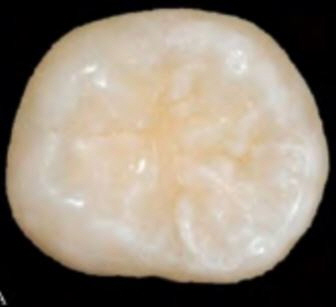

image.shape : (224, 224, 3)
label[1] : jellyfish, label[2]*100:.2f : 56.30


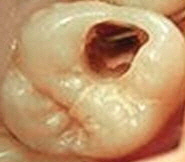

image.shape : (224, 224, 3)
label[1] : tick, label[2]*100:.2f : 10.93


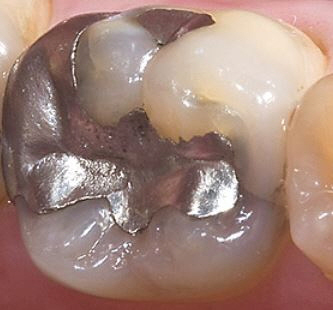

image.shape : (224, 224, 3)
label[1] : conch, label[2]*100:.2f : 31.76


In [4]:
for file in files:
    predict_vgg16(model, file)


## 데이터 증강(aug)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = './train'
validation_dir = './test'
batch_size = 32
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
        rotation_range=180, # 회전 최대 20도
        width_shift_range=0.2, # 좌우 이동
        height_shift_range=0.2, #상하 이동
        horizontal_flip=True, #좌우 반전
        vertical_flip=True, #상하 반전
        )
#검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator()

#학습에 사용될 데이터생성기
train_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size), # (224,224)
        batch_size = batch_size, # 32
        class_mode='categorical', # 폴더구조이므로 
        shuffle=True)

#검증에 사용될 데이터생성기
validation_generator=validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_num=len(train_generator.class_indices) # 3  # 0 1 2
custom_labels=list(validation_generator.class_indices.keys()) # cured decayed healthy

Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.



## FC 레이어 새로 정의

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers
import keras.backend as K

In [7]:
K.clear_session() #새로운 세션으로 시작 (메모리  clear)

from keras.applications import VGG16
conv_layers = VGG16(weights='imagenet', include_top=False, # Dense(1000) layer 사용하지 않겠다(왜냐하면 3개 class 사용)
                    input_shape=(image_size,image_size,3))
conv_layers.summary() #conv layer만

# Convolution Layer를 학습되지 않도록 고정 # transferlation 전이학습(feature engineering 부분 활용하자)
for layer in conv_layers.layers:
    layer.trainable = False
    
#new model
model=models.Sequential()
model.add(conv_layers)

# model Fully Connected 재구성
model.add(layers.Flatten())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(class_num, activation='softmax'))

# 전체 모델
model.summary()

vgg16_model_path = 'new_trained_from_vgg16.h5'
model.save(vgg16_model_path)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     


## 모델 학습

In [8]:
from keras.models import load_model

model = load_model(vgg16_model_path)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6), # -4 loss 출렁거림
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
model.save(vgg16_model_path)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/100
2/1 [================================] - 5s 2s/step - loss: 13.3892 - acc: 0.2333 - val_loss: 7.6695 - val_acc: 0.3167
Epoch 2/100
2/1 [================================] - 1s 423ms/step - loss: 11.5395 - acc: 0.4167 - val_loss: 7.9666 - val_acc: 0.3167
Epoch 3/100
2/1 [================================] - 1s 423ms/step - loss: 13.7612 - acc: 0.3167 - val_loss: 7.8062 - val_acc: 0.3167
Epoch 4/100
2/1 [================================] - 1s 421ms/step - loss: 13.2571 - acc: 0.3167 - val_loss: 7.9158 - val_acc: 0.3000
Epoch 5/100
2/1 [================================] - 1s 422ms/step - loss: 12.5350 - acc: 0.3333 - val_loss: 7.7621 - val_acc: 0.3000
Epoch 6/100
2/1 [================================] - 1s 458ms/step - loss: 10.7711 - acc: 0.3167 - val_loss: 8.0034 - val_acc: 0.3000
Epoch 7/100
2/1 [================================] - 1s 495ms/step - loss: 16.2273 - acc: 0.2500 - val_loss: 7.8767 - val_acc: 0.3000
Epoch 8/100
2/1 [================================] - 1s 484ms/ste

Epoch 62/100
2/1 [================================] - 1s 422ms/step - loss: 10.0317 - acc: 0.3167 - val_loss: 4.2613 - val_acc: 0.4333
Epoch 63/100
2/1 [================================] - 1s 425ms/step - loss: 10.2411 - acc: 0.3833 - val_loss: 4.2087 - val_acc: 0.4667
Epoch 64/100
2/1 [================================] - 1s 426ms/step - loss: 8.3310 - acc: 0.4333 - val_loss: 4.2976 - val_acc: 0.4500
Epoch 65/100
2/1 [================================] - 1s 430ms/step - loss: 9.7048 - acc: 0.3333 - val_loss: 4.2454 - val_acc: 0.4500
Epoch 66/100
2/1 [================================] - 1s 423ms/step - loss: 9.1544 - acc: 0.4000 - val_loss: 4.1760 - val_acc: 0.4500
Epoch 67/100
2/1 [================================] - 1s 423ms/step - loss: 9.7783 - acc: 0.4667 - val_loss: 4.0750 - val_acc: 0.4667
Epoch 68/100
2/1 [================================] - 1s 450ms/step - loss: 9.9102 - acc: 0.3667 - val_loss: 3.9770 - val_acc: 0.4833
Epoch 69/100
2/1 [================================] - 1s 449


## accuracy loss graph

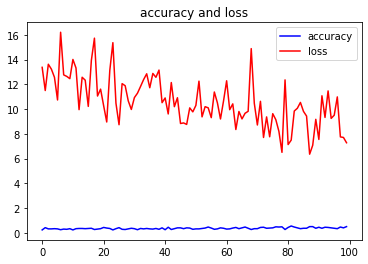

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
loss = history.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='accuracy')
plt.plot(epochs, loss, 'r', label='loss')
plt.title('accuracy and loss')
plt.legend()
  
plt.show()
# loss graph 출렁거린다 ==> 데이터 적다, learning rate 크다


## new model Classification

In [10]:
import numpy as np

def predict_custom_vgg16(model, filename) :

  image = load_img(filename)
  display(image)
  
  image = load_img(filename, target_size=(224, 224))

  image = img_to_array(image)
  image = image.reshape((1, 224, 224, 3))
  
  image = vgg16.preprocess_input(image)
  
  yhat = model.predict(image) 

  # 최대 출력 인덱스를 구한다.
  idx=np.argmax(yhat[0])
    
  print(f'custom_labels[idx] : {custom_labels[idx]}, yhat[0][idx]*100 : {yhat[0][idx]*100}')

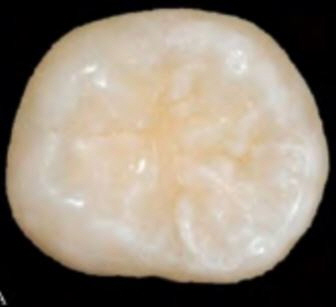

custom_labels[idx] : decayed, yhat[0][idx]*100 : 99.30323362350464


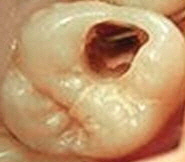

custom_labels[idx] : cured, yhat[0][idx]*100 : 100.0


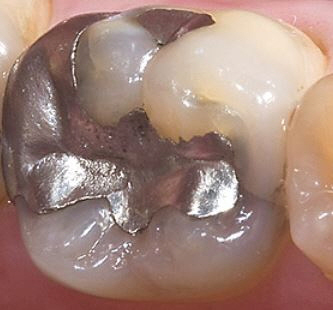

custom_labels[idx] : cured, yhat[0][idx]*100 : 100.0


In [11]:
from keras.models import load_model

model = load_model(vgg16_model_path)
  
files = [
    './test/healthy/1.jpg',
    './test/decayed/101.jpg',
    './test/cured/301.jpg'
        ]
  
for file in files :
  predict_custom_vgg16(model, file)    